In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.simplefact import *
from src.simplefact import Reasoner as FACT
from src.ontofun import *
from src.syntax import *
from src.reasoneur import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_owl('local/manchester-pizza.owl')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = FACT(n_concepts=onto.n_concepts, n_roles=onto.n_roles, timeout=10_000)
for axiom in onto.tbox:
    fact.add_axiom(axiom)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

<Onto 99 concepts, 3 roles, 280 axioms>

In [4]:
rng = np.random.default_rng(seed)
Nc = onto.n_concepts
Nr = onto.n_roles
gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4)
        
n_queries = 30_000
queries, answers, qset = [], [], set()
while len(queries) < n_queries:
    #print(f'\r{len(queries)}/{n_queries}', end='')
    axiom = gen()
    if axiom in queries: continue
    
    answer = fact.check_axiom(axiom)
    queries.append(axiom); answers.append(float(answer)); qset.add(axiom)
    
print(to_pretty(queries[100], onto=onto))
print(len(answers))
print(np.round(np.mean(answers), 4))

VegetarianPizza ⊔ CheesyVegetableTopping != OliveTopping
30000
0.3688


In [5]:
Reasoner = ContextFreeReasoner
Encoder = NNExprEncoder
Optimizer = T.optim.AdamW
expr_size = 10

hidden_size = 16
epoch_count = 30 + 1
batch_size = 32
lr_reasoner = 0.002
lr_encoder = lr_reasoner

X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)

test_history = []
test_history_by_onto = []
rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = Reasoner(expr_size=expr_size, hidden_size=hidden_size)
#reasoner.load_state_dict(T.load('local/out/exp/20220529T021116/reasoner.pt'))
freeze(reasoner)
#reasoner_optim = Optimizer(reasoner.parameters(), lr=lr_reasoner)
encoder = Encoder.from_onto(onto, expr_size=expr_size)
encoder_optim = Optimizer(encoder.parameters(), lr=lr_encoder)
print(paramcount(reasoner))
print(paramcount(encoder))

test(test_data=(idx_te, X_te, y_te), test_onto=[onto],
     reasoner=reasoner, reasoner_name='pizza_reasoner',
     encoders=[encoder], optimizers=[encoder_optim],
     test_hist=test_history, test_hist_by_onto=test_history_by_onto,
     epoch_count=epoch_count, batch_size=batch_size)

3283
1330
test epoch 01/31 | batch 938/938 | test loss 0.7053 | acc 0.3688 | f1 0.5388 | prec 0.3688 | recall 1.0000 | roc auc 0.5974 | elapsed 8.35s
test epoch 02/31 | batch 938/938 | test loss 0.6706 | acc 0.6725 | f1 0.6824 | prec 0.5311 | recall 0.9540 | roc auc 0.8606 | elapsed 12.60s
test epoch 03/31 | batch 938/938 | test loss 0.6416 | acc 0.7109 | f1 0.7074 | prec 0.5643 | recall 0.9476 | roc auc 0.8821 | elapsed 12.65s
test epoch 04/31 | batch 938/938 | test loss 0.6252 | acc 0.7420 | f1 0.7297 | prec 0.5946 | recall 0.9441 | roc auc 0.8804 | elapsed 12.56s
test epoch 05/31 | batch 938/938 | test loss 0.6157 | acc 0.7477 | f1 0.7306 | prec 0.6025 | recall 0.9280 | roc auc 0.8645 | elapsed 12.69s
test epoch 06/31 | batch 938/938 | test loss 0.6099 | acc 0.7500 | f1 0.7324 | prec 0.6049 | recall 0.9280 | roc auc 0.8480 | elapsed 12.63s
test epoch 07/31 | batch 938/938 | test loss 0.6062 | acc 0.7519 | f1 0.7337 | prec 0.6071 | recall 0.9271 | roc auc 0.8366 | elapsed 12.78s
test

In [6]:
with T.no_grad():
    reasoner.eval()
    _, _, Y_te = eval_batch(reasoner, [encoder], X_te, y_te, idx_te)

,mean,std,micro
acc,0.756833,NaN,0.756833
prec,0.612841,NaN,0.612841
recall,0.924885,NaN,0.924885
f1,0.737202,NaN,0.737202
auc_roc,0.781587,NaN,0.781587
ap,0.606816,NaN,0.606816


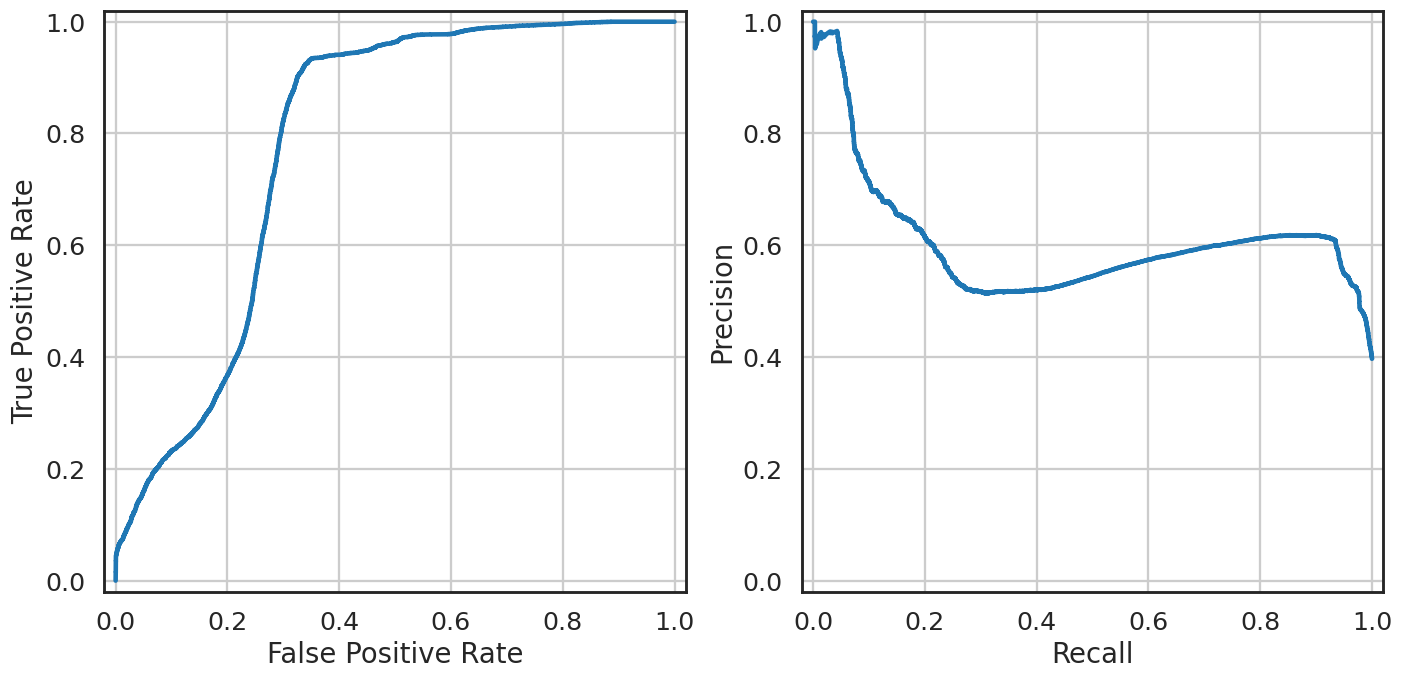

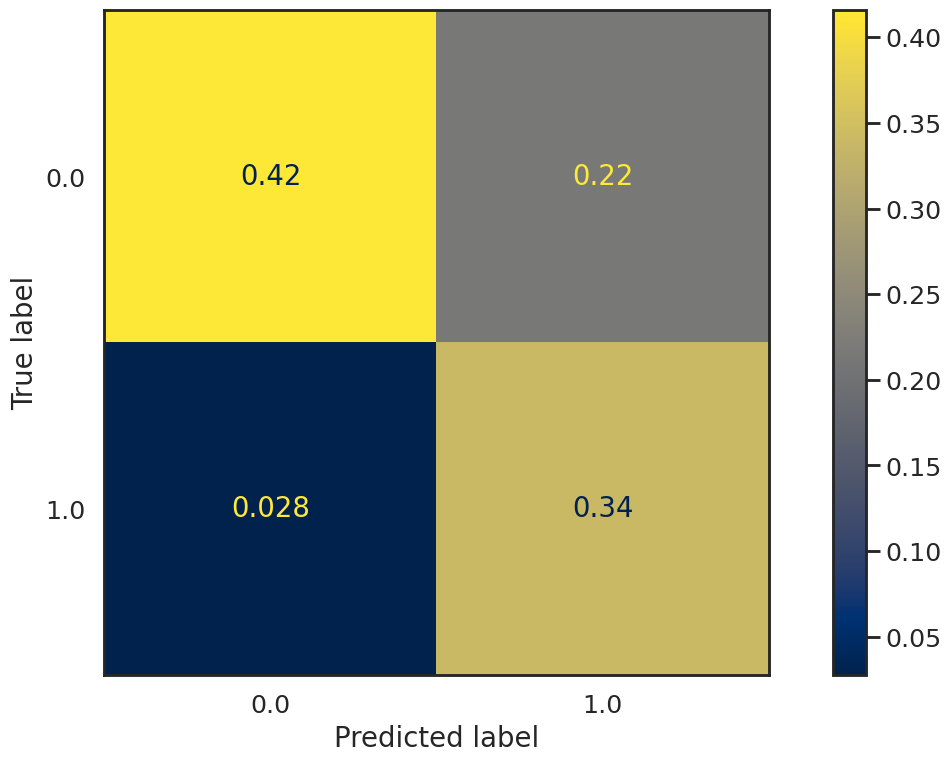

In [7]:
test_history_by_onto = pd.DataFrame(test_history_by_onto)
test_history = pd.DataFrame(test_history)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te))
report([onto], y_te, Y_te, idx_te)

In [8]:
pizzann = ReasonerPackage(reasoner, encoder)

2022-06-22 09:10:24.380120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 09:10:24.380138: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


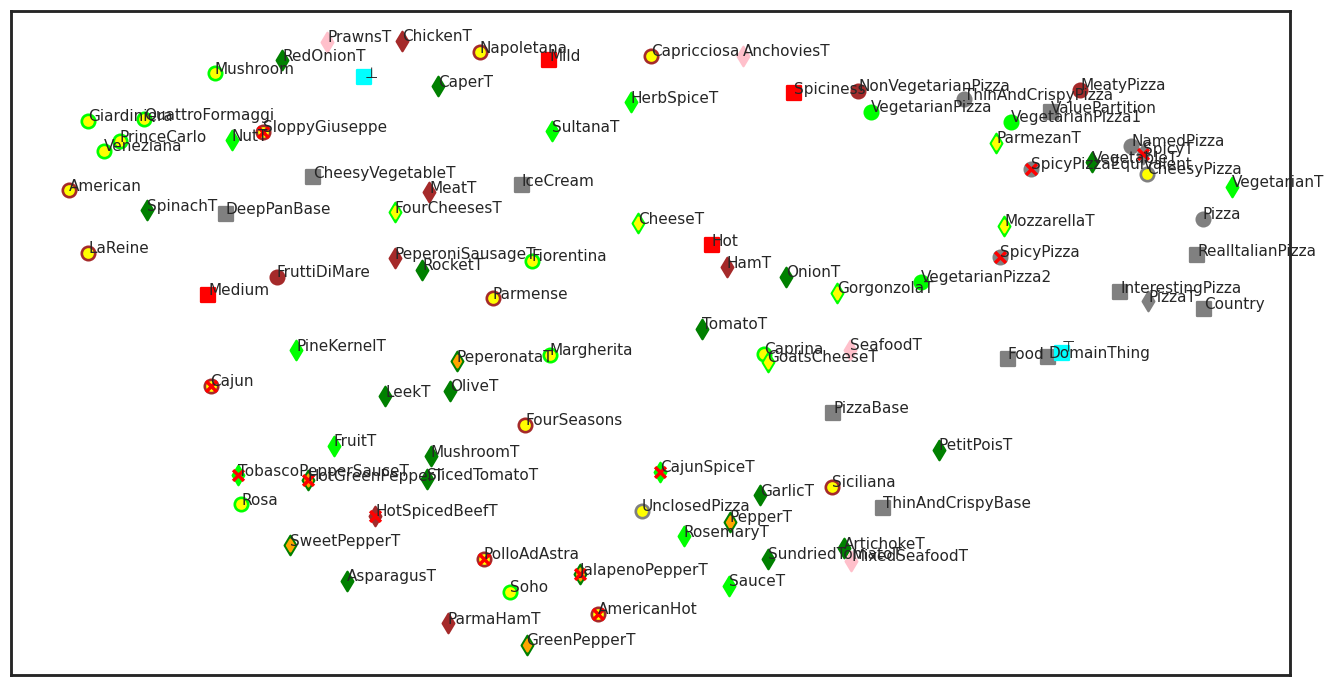

In [9]:
from umap import UMAP
pca = UMAP(n_components=2, n_neighbors=50, min_dist=0.2, random_state=seed)

exclude = {}
manual_exprs = [C[x] for x in C if x not in exclude]
manual_exprs += [TOP, BOT]

exprs, texts, colors, markers = [], [], [], []
for expr in manual_exprs:
    exprs.append(pizzann.encode(expr))
    texts.append(to_pretty(expr, onto=onto))
    
    if fact.check_eqv(expr, BOT):
        m = 's'
    elif fact.check_sub(expr, C.Pizza):
        m = 'o'
    elif fact.check_sub(expr, C.PizzaTopping):
        m = 'd'
    else:
        m = 's'
    
    c = 'gray'
    if isinstance(expr, tuple) or expr in {TOP, BOT}:
        c = 'cyan'
        m = 's'
    elif not fact.check_sub(expr, BOT):
        if fact.check_sub(expr, C.VegetarianPizza): c = 'lime'
        if fact.check_sub(expr, C.NonVegetarianPizza): c = 'brown'

        if fact.check_sub(expr, C.VegetarianTopping): c = 'lime'
        if fact.check_sub(expr, C.VegetableTopping): c = 'green'
        if fact.check_sub(expr, C.MeatTopping): c = 'brown'
        if fact.check_sub(expr, C.SeafoodTopping): c = 'pink'
        if fact.check_sub(expr, C.Spiciness): c = 'red'
    
    colors.append(c)
    markers.append(m)

xs, ys = pca.fit_transform(np.array(exprs)).T
for x, y, text, color, marker, expr in zip(xs, ys, texts, colors, markers, manual_exprs):
    plt.scatter(x, y, marker=marker, color=color)
    if not (isinstance(expr, tuple) or fact.check_sub(expr, BOT)):
        if fact.check_sub(expr, (OR, C.CheeseTopping, C.CheesyPizza)):
            plt.scatter(x, y, marker=marker, color='yellow', s=30)
        if fact.check_sub(expr, C.PepperTopping):
            plt.scatter(x, y, marker=marker, color='orange', s=30)
        if fact.check_sub(expr, (OR, C.SpicyTopping, C.SpicyPizza)):
            plt.scatter(x, y, marker='x', color='red', s=50)
    plt.text(x, y, text.replace('Topping', 'T'), fontsize=10)
    
#plt.xlim(7.3, 11.7)
plt.xticks([]); plt.yticks([])
plt.show()

In [10]:
df = []
for x, y, Y_proba in zip(X_te, y_te, Y_te):
    y, Y = bool(y), bool(Y_proba > 0.5)
    ok = y == Y 
    df.append(dict(
        y=y, Y=Y, correct=y == Y, proba=round(Y_proba, 6),
        depth=expr_depth(x),
        lbot=fact.check_eqv(x[1], BOT),
        rtop=fact.check_eqv(x[2], TOP),
        disj=x[0] == DIS,
        trivialeq=x[1] == x[2],
        axiom=to_pretty(x, onto=onto),
    ))
            
df = pd.DataFrame(df)
print(df.correct.mean())
df

0.7568333333333334


,y,Y,correct,proba,depth,lbot,rtop,disj,trivialeq,axiom
0,False,False,True,0.290487,1,False,False,False,False,ValuePartition ⊑ SweetPepperTopping
1,False,True,False,0.525308,5,False,False,False,False,SweetPepperTopping ⊓ ¬(∃hasBase.¬PineKernelTop...
2,False,False,True,0.333249,1,False,False,False,False,Hot ⊑ VegetableTopping
3,True,True,True,0.520607,2,True,False,False,False,Veneziana ⊓ CajunSpiceTopping ⊑ ⊥
4,True,True,True,0.527667,3,True,False,False,False,¬Capricciosa ⊓ Capricciosa ⊑ ⊥
...,...,...,...,...,...,...,...,...,...,...
29995,False,True,False,0.521084,3,False,False,False,False,PeperoniSausageTopping ⊓ ¬QuattroFormaggi ⊑ ⊥
29996,False,True,False,0.501047,2,False,False,False,False,CheesyPizza ⊓ QuattroFormaggi ⊑ ⊥
29997,False,False,True,0.433628,5,False,False,False,False,∃hasBase.¬(¬PeperoniSausageTopping ⊓ ¬SpicyPiz...
29998,False,True,False,0.530494,6,False,False,False,False,¬(⊤ ⊓ ¬LeekTopping ⊓ ¬LeekTopping) ⊓ RealItali...


In [11]:
df.groupby('correct').mean()

,y,Y,proba,depth,lbot,rtop,disj,trivialeq
correct,,,,,,,,
False,0.113914,0.886086,0.511020,3.561343,0.050446,0.001645,0.0,0.009733
True,0.450650,0.450650,0.438074,2.247038,0.432063,0.012332,0.0,0.000176


In [12]:
print('correct', sum(df.correct))
print('incorrect', sum(~df.correct))

correct 22705
incorrect 7295


In [13]:
xs = sorted(list(range(onto.n_concepts)), key=lambda i: onto.concepts[i])
ticks = [to_pretty(x, onto=onto).replace('Topping', 'T') for x in xs]
n = len(xs)
sub_fact = np.zeros((n, n))
sub_nn = np.zeros((n, n))
for i, c in enumerate(xs):
    for j, d in enumerate(xs):
        sub_fact[i][j] = fact.check_sub(c, d)
        sub_nn[i][j] = pizzann.check_sub(c, d)

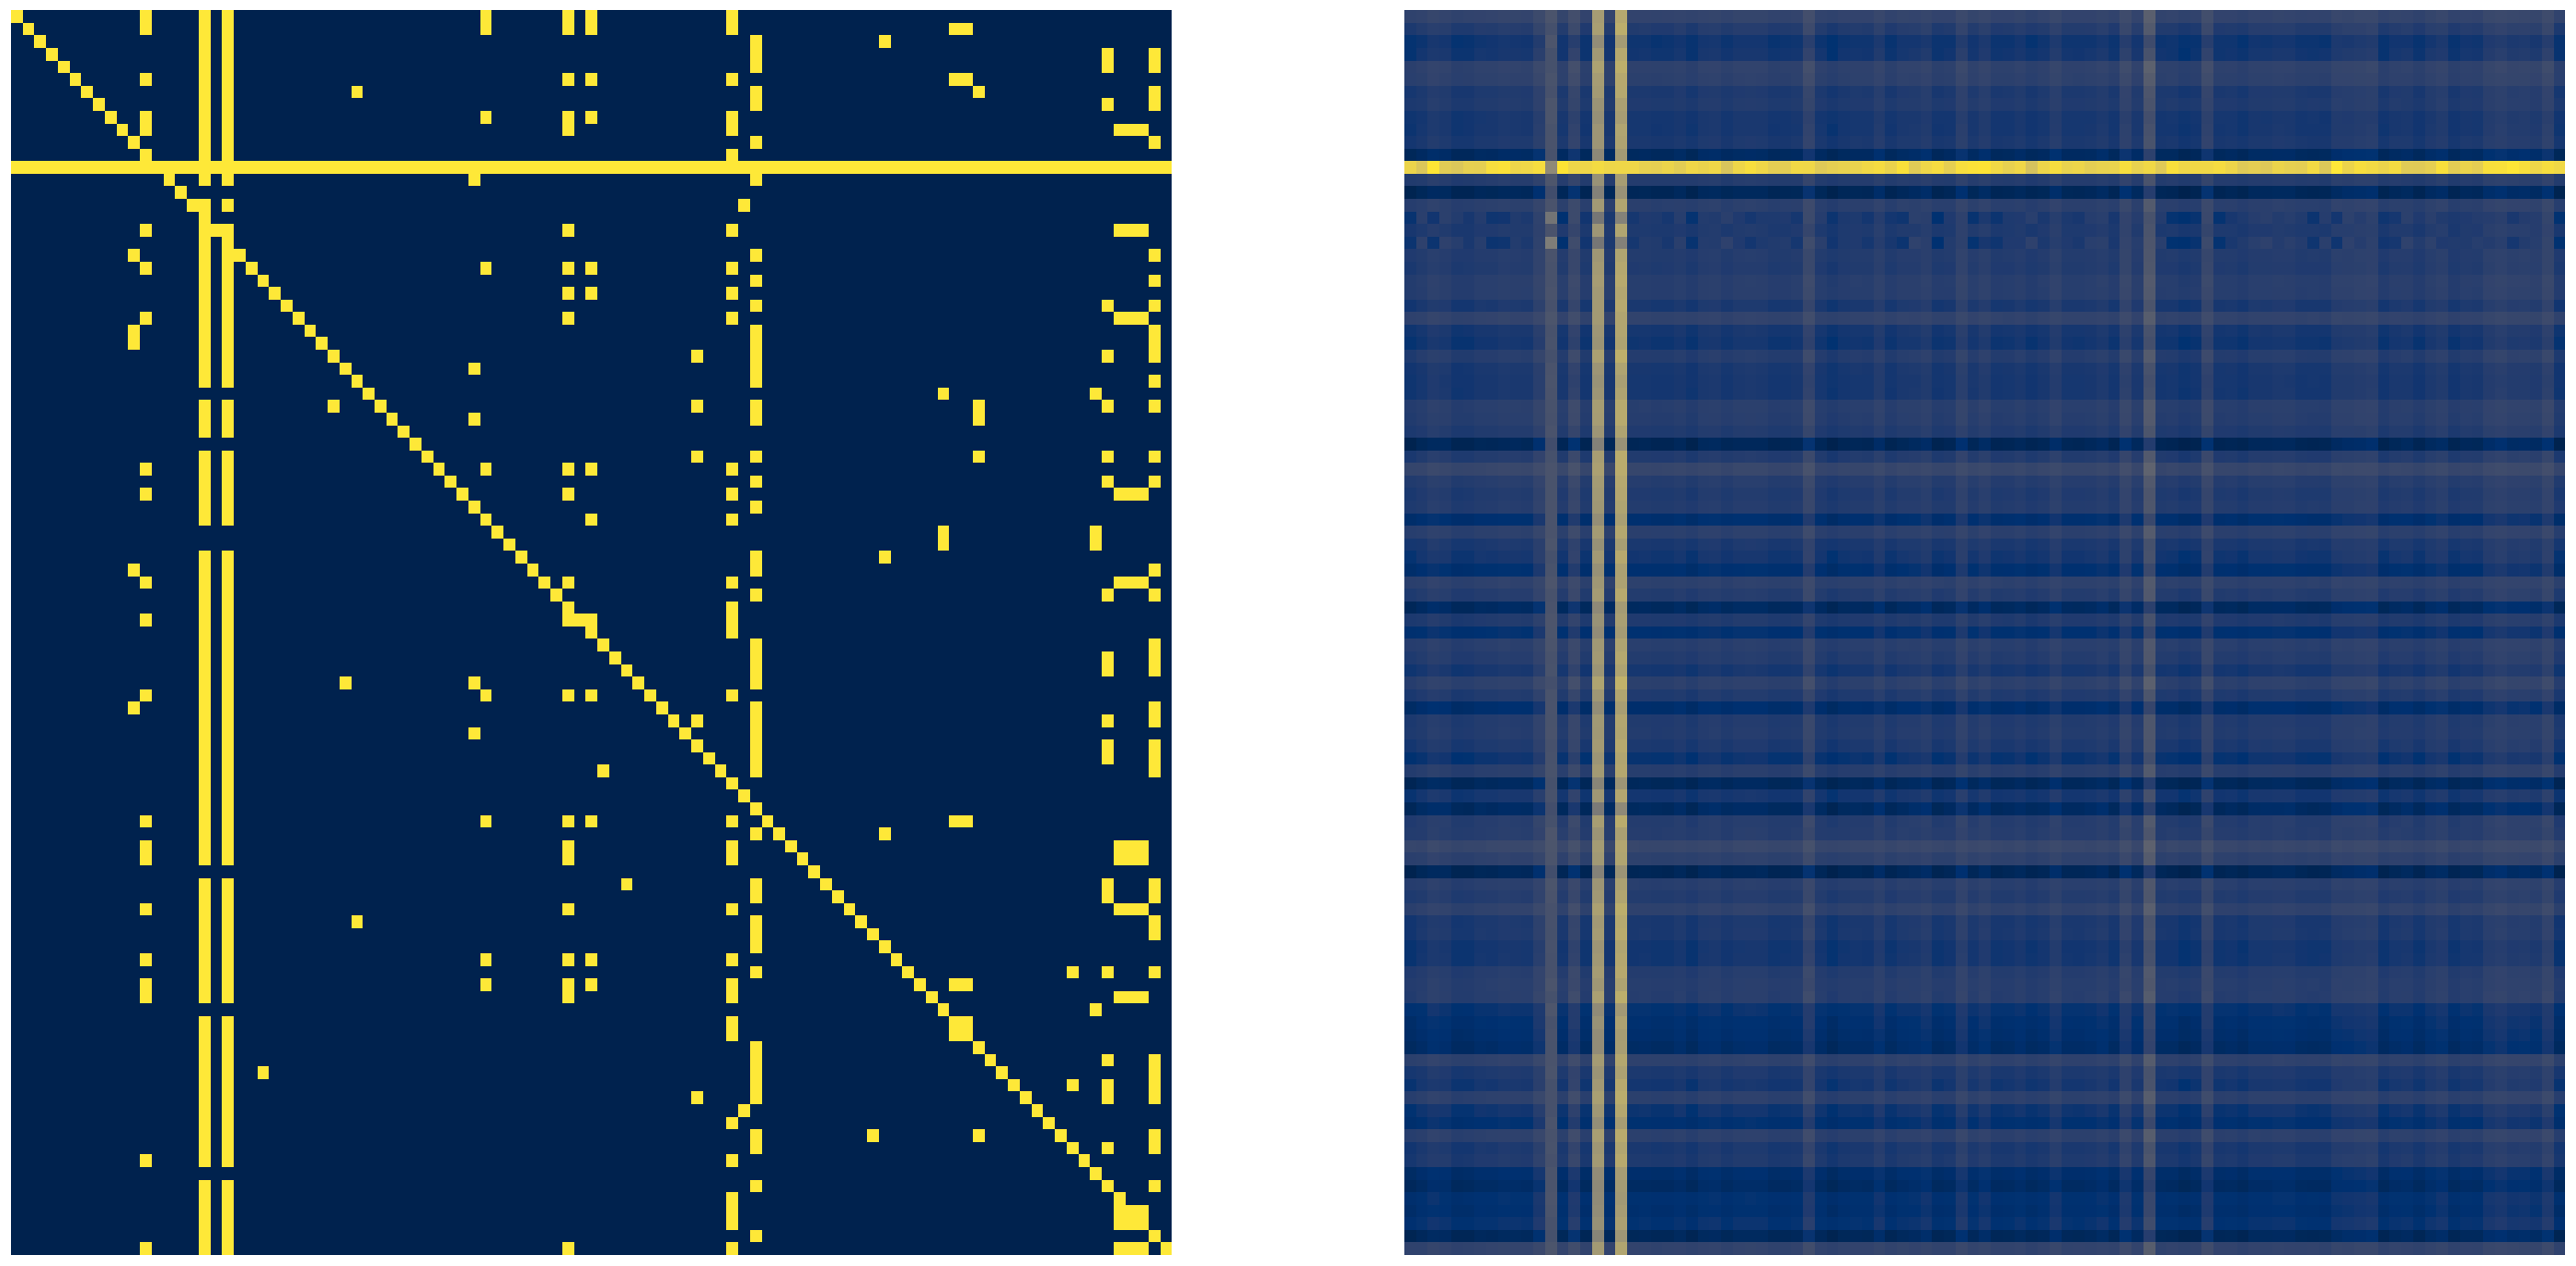

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30, 15))
sns.heatmap(sub_fact, xticklabels=ticks, yticklabels=ticks, cbar=False, cmap='cividis', ax=ax1)
sns.heatmap(sub_nn, xticklabels=ticks, yticklabels=ticks, cbar=False, cmap='cividis', ax=ax2)

#ax1.tick_params(axis='both', labelsize=8.9)
#ax2.tick_params(axis='both', labelsize=8.9)
for ax in [ax1, ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.grid(True)
plt.show()

In [15]:
test_history.groupby('test_epoch').max().elapsed.sum()

287.2176504135132